Creating a SentencePiece Tokenizer on the new sentences (without considering the definitions)
----------------------------------
We extracted new sentences from the book <i style="color: cyan">Grammaire de Wolof Moderne</i> by Pathé Diagne. Since we want to test the relevancy of the new sentences to our translation task, let us create a tokenizer for them. 

The process is almost the same as in [processing_4](text_processing4.ipynb) excepted that we will create another custom dataset for the custom transformer model.

Let us import the necessary libraries.

In [2]:
# # for creating the tokenizer
from tokenizers import (
    decoders,
#     SentencePieceBPETokenizer,
#     normalizers,
#     pre_tokenizers,
)
# from transformers import AutoTokenizer, PreTrainedTokenizerFast, T5TokenizerFast

import sentencepiece as spm

# for importing and manipulating the sentences
import pandas as pd
import random

# for plotting the box plot of the sequence lengths
import plotly.express as px

# for loading sentences with the custom dataset
from torch.utils.data import DataLoader

#### Load dataset and create generator

We will create one tokenizer for both of the French and Wolof corpora because the `T5` model' understand only one embedding layer. So we must create one generator for both of the French and Wolof corpora. 

In [3]:
# load sentences
sentences = pd.read_csv("data/extractions/new_data/sentences.csv")

# initialize a batch size
BATCH_SIZE = 400

# create generators (for the corpora)
# def generate_sents():
    
#     # recuperate the sentences
#     french_sents = sentences['french'].to_list() 
    
#     wolof_sents = sentences['wolof'].to_list() 
    
#     sents = french_sents + wolof_sents
    
#     for i in range(1, len(sents), BATCH_SIZE):
        
#         yield sents[i:i+BATCH_SIZE]

with open('sents.txt', 'w', encoding='utf-8') as f:
    for sent in sentences['french'].to_list() + sentences['wolof'].to_list():
        f.write(sent + '\n')


#### Initialize the tokenizer

In [4]:
# tokenizer = SentencePieceBPETokenizer()

#### Add normalizer

In [5]:
# tokenizer.normalizer = normalizers.Replace(" {2,}", " ")

#### Configure the pre-tokenizers

We will use the Metaspace pre-tokenizer which separates the words considering the spaces between them. It will replace the space by a character (by default the underscore "_").

In [6]:
# tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

#### Initialize the special tokens

In [7]:
special_tokens = ['<pad>', '</s>', '<unk>']

In [8]:
# trainer = trainers.UnigramTrainer(special_tokens=special_tokens, unk_token = "<unk>") # let us take the default vocab size

#### Train the tokenizer and save it

The SentencePiece tokenizer automatically performs a normalization (the `NFKC` Unicode). 

In [9]:
spm.SentencePieceTrainer.Train(input = f'sents.txt',
                               model_prefix='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v3',
                               vocab_size=1500,
                               character_coverage=1.0,
                               pad_id=0,                
                               eos_id=1,
                               unk_id=2,
                               bos_id=3,
                               pad_piece='<pad>',
                               eos_piece='</s>',
                               unk_piece='<unk>',
                               bos_piece='<s>',
                               )

Load the tokenizer.

In [10]:
tokenizer = spm.SentencePieceProcessor(model_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v3.model')

#### Make a little example

Let us recuperate random sentences from the corpora and tokenize them.

In [11]:
random.seed(200)

french_sentence = random.choice(sentences['french'])

wolof_sentence = random.choice(sentences['wolof'])

In [12]:
# print the french sentence
french_sentence

'Fais sortir tout cheval que tu vois !'

In [13]:
# print the wolof sentence
wolof_sentence

'Yeena doon dem'

In [14]:
french_encoding = tokenizer.Encode(french_sentence, add_eos=True)

print("French tokens")
print([tokenizer.IdToPiece(id) for id in french_encoding])

print("French ids")
print(french_encoding)

French tokens
['▁Fa', 'is', '▁sortir', '▁tout', '▁cheval', '▁que', '▁tu', '▁vois', '▁!', '</s>']
French ids
[195, 185, 501, 143, 396, 23, 49, 235, 7, 1]


In [15]:
wolof_encoding = tokenizer.Encode(wolof_sentence, add_eos=True)

print("Wolof tokens")
print([tokenizer.IdToPiece(id) for id in wolof_encoding])

print("Wolof ids")
print(wolof_encoding)

Wolof tokens
['▁Yee', 'na', '▁doon', '▁dem', '</s>']
Wolof ids
[838, 248, 213, 14, 1]


#### Creating the T5 custom dataset for the new sentences

In [16]:
from transformers import T5TokenizerFast

wrapped_tokenizer1 = T5TokenizerFast(
    vocab_file='wolof-translate/wolof_translate/tokenizers/t5_tokenizers/tokenizer_v3.model'
)


c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us give them the sentences that we use as example. 

In [17]:
wf_encoding = wrapped_tokenizer1(french_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [195, 185, 501, 143, 396, 23, 49, 235, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [18]:
wf_encoding = wrapped_tokenizer1(wolof_sentence, max_length=40, padding='max_length', truncation=True)

wf_encoding

{'input_ids': [838, 248, 213, 14, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Let us decode the wolof sentence.

In [19]:
wrapped_tokenizer1.convert_tokens_to_ids(['<pad>', '</s>', '<unk>'])

[0, 1, 2]

In [20]:
wrapped_tokenizer1.decode(wf_encoding.input_ids, skip_special_tokens=True)

'Yeena doon dem</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

Let us verify, before creating the custom dataset, the max length that we can get from the corpora' tokens without considering the augmentation. We must for that trace the box plot of the lengths and identify the range in which we will sample the max length of the sequences.

In [35]:
length = []

for i in range(sentences['french'].shape[0]):
    
    sent1 = sentences['french'][i]
    
    sent2 = sentences['wolof'][i]
    
    len_ids = max(len(wrapped_tokenizer1(sent1).input_ids), len(wrapped_tokenizer1(sent2).input_ids))
    
    length.append(len_ids)

        

In [36]:
# trace the histogram of the length with a appropriate template and labels with indian red color with displayed counts
fig = px.histogram(length, template="plotly_dark", labels=dict(x="Length of the sentences", y="Number of sentences"), color_discrete_sequence=['indianred'], marginal="box", nbins=100)

fig.show()

The upper fence is of **20** and the max length is equal to **48**. Then we will test any value between the two. 

We can also use a buckets by lengths. For that we can take as first boundary the upper fence and then determine another limits. Let us take for that dataset the following boundaries got with the histogram:

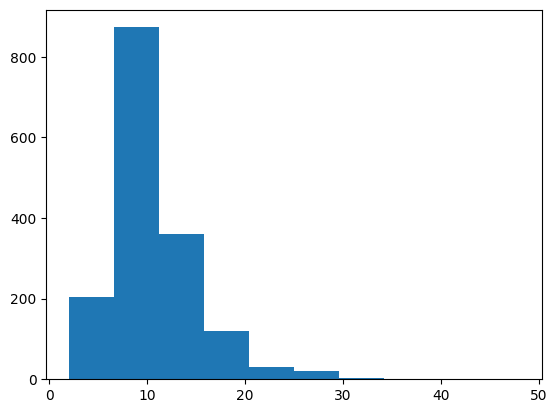

In [37]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt

# Create histogram
hist, bins, _ = plt.hist(length, bins=10)  # Adjust the number of bins as needed

# Analyze the histogram
# Identify peaks or gaps to determine the boundaries

# Choose the boundaries based on the analysis
boundaries = [ceil(bins[0])] + [ceil(bin) for bin, count in zip(bins[1:], hist) if count > 10] + [np.inf]

In [38]:
bins

array([ 2. ,  6.6, 11.2, 15.8, 20.4, 25. , 29.6, 34.2, 38.8, 43.4, 48. ])

In [39]:
hist

array([205., 873., 361., 120.,  31.,  20.,   4.,   0.,   0.,   1.])

We trace 10 bins and if the number of sequences in a bin is higher than 10 we take the length as a boundary:

In [40]:
boundaries

[2, 7, 12, 16, 21, 25, 30, inf]

But considering the augmentation we can obtain more than the value that we will take because it will add modifications on the words and then it can recognize only parts of them and divide them in multiple other tokens. We will add to the max length the fifth of it. 

In [27]:
%run wolof-translate/wolof_translate/data/dataset_v4.py

Let us generate some data with their masks and decode the labels.

**Note that we will use, when training the `T5 model`, train and test sets and not directly the full dataset**

In [28]:
# t5_tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# wrapped_tokenizer1.eos_token_id = t5_tokenizer.eos_token_id

# wrapped_tokenizer1.pad_token_id = t5_tokenizer.pad_token_id

# wrapped_tokenizer1.unk_token_id = t5_tokenizer.unk_token_id

In [29]:
# Initialize our custom dataset
dataset = SentenceDataset("data/extractions/new_data/sentences.csv", wrapped_tokenizer1, truncation=True, max_len = 20)

In [30]:
generator = torch.manual_seed(5)
input_ids, input_mask, labels, _ = next(iter(DataLoader(dataset, 10, shuffle=True, generator=generator))) # generate 10 sentences with shuffling

Let us print the input ids.

In [31]:
input_ids

tensor([[ 195,  185,  501,  143,  107,   23,   49,  235,    7,    1,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 139,  157,  274,   11,   73,    5,    8,    1,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 127,   48,   20,  354,   43,   63,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,

In [32]:
input_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

In [33]:
labels

tensor([[ 669,  319,  104,  221,   97,    7,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 195,   46,   25,  339,    8,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  26,   29,   19,   69,  330,    1,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,

Let us decode the labels.

In [34]:
dataset.decode(labels)

['Génnéel mépp xar moo gis!',
 'Fan ŋga jëm?',
 'Góor gii demoon',
 'Yaa ka gis moom.',
 'Góor gii bëggóon',
 'Ñooñu, ñépp dañuy dem!',
 'Dafa di dem.',
 'Soo demee, kookule la!',
 'Gis na keneen ki woon.',
 'Bëgg naa tuuti xaalis ci yaw']